<h1 style="color:red"><center> Machine Learning Operations Engineer(MLOps)</center></h1>

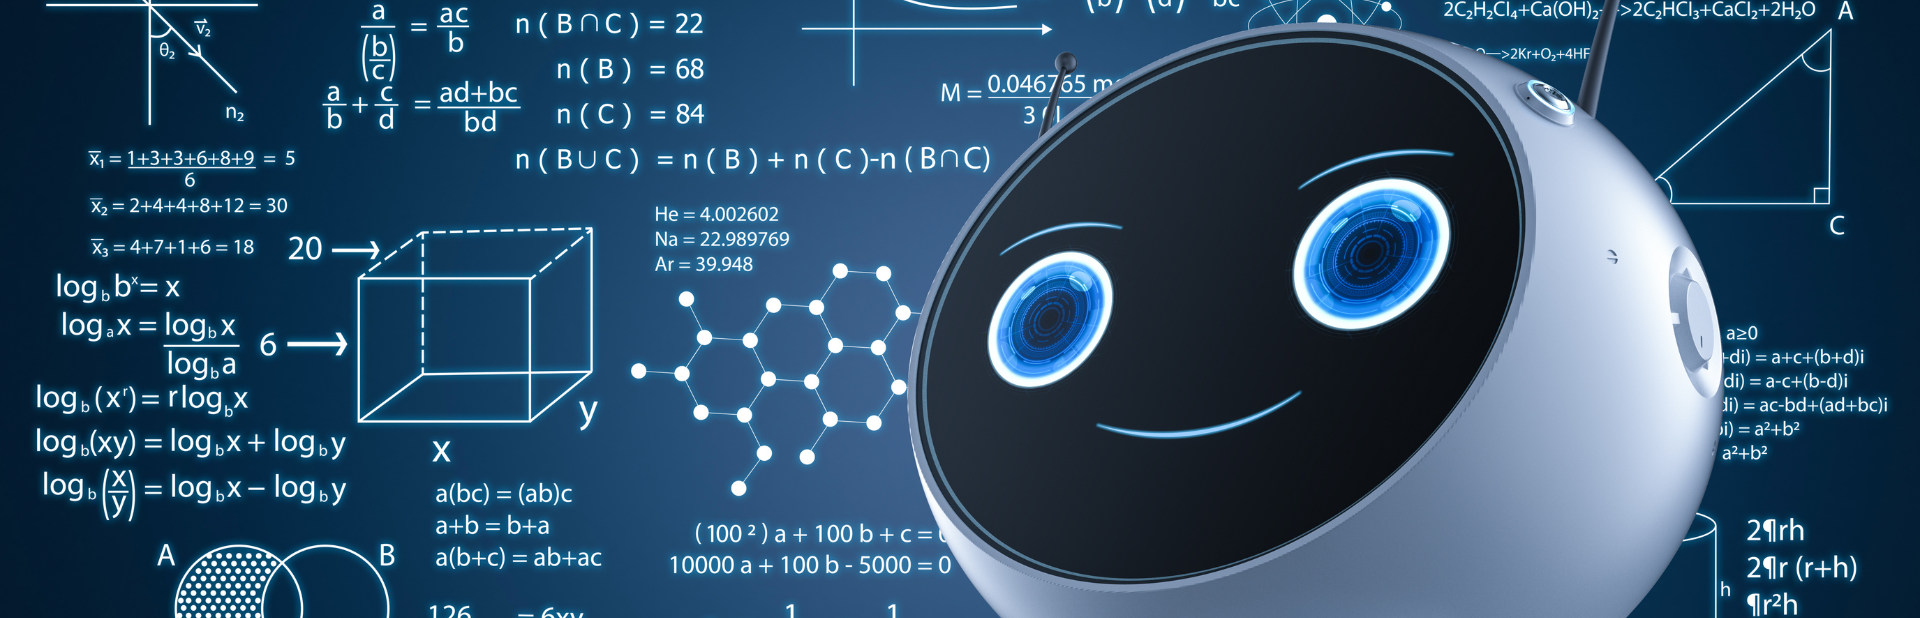

In [114]:
# Importando las librerías
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,  r2_score

In [115]:
# Cargando datos desde el archivo 'steam_games.json' en un DataFrame
rows = []

with open('steam_games.json') as f:
    for line in f.readlines():
        rows.append(ast.literal_eval(line))

df = pd.DataFrame(rows)

In [116]:
df.loc[df['app_name']=='Rocksmith® 2014 – Aerosmith Song Pack']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
1845,NaN,"[Casual, Simulation]",Rocksmith® 2014 – Aerosmith Song Pack,Rocksmith® 2014 – Aerosmith Song Pack,http://store.steampowered.com/app/271415/Rocks...,2014-01-07,"[Casual, Simulation]",NaN,http://steamcommunity.com/app/271415/reviews/?...,"[Single-player, Shared/Split Screen, Downloada...",11.99,False,271415,Ubisoft - San Francisco,NaN,NaN


## Exploración y Procesamiento
■ El objetivo de esta sección es llevar a cabo el análisis exploratorio y la transformación del conjunto de datos 'steam_games.json'. Estas acciones prepararán los datos para un modelamiento adecuado, lo que permitirá realizar predicciones más precisas mediante modelos de Machine Learning.

In [ ]:
# Vista previa de las primeras 4 filas del DataFrame
df.head(4)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN


In [ ]:
# Información general del DataFrame, como tipos de datos y valores faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [ ]:
# Comprobando si hay valores nulos en el DataFrame
df.isnull().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

# Primer Grupo de Transformaciones
 <h3>(Columns= ['early_access', 'price', 'release_date'])</h3>

■ Se eliminan las columnas del DataFrame que no serán utilizadas en el modelamiento

■ Se convierte la columna 'early_access' a tipo entero para representar valores de acceso anticipado como '1' y no acceso anticipado como '0'

■ Se asigna el valor '0' a las filas donde 'price' contiene las palabras "free" o "free to play"

■ Se convierte cualquier valor no numérico en la columna 'price'  en NaN (Not a Number)

■ Se convierte la columna 'price' a tipo numérico (float) para asegurar que todos los valores sean números decimales

■ Se rellenan los valores faltantes en las columnas 'price' y 'release_date' con la moda (el valor más frecuente) de cada columna

■ Se modifica la columna 'release_date' creando una nueva columna 'year' que contiene el año de lanzamiento, y otra columna 'month' que contiene el mes de lanzamiento

In [ ]:
# Eliminando las columnas que no serán tenidas en cuenta para el modelamiento
columnas_a_eliminar = ['app_name', 'publisher', 'title', 'url', 'discount_price', 'reviews_url', 'id', 'developer', 'sentiment', 'metascore']
df.drop(columnas_a_eliminar, axis=1, inplace=True)

In [ ]:
# Convirtiendo la columna 'early_access' a tipo entero
df["early_access"] = df["early_access"].astype('Int64')

In [ ]:
# Procesando los datos de la columna 'price' aplicando una mascara
mask = df['price'].str.contains(r'free|to play', case=False, na=False)
df.loc[mask, 'price'] = 0

print(df['price'])

0        4.99
1           0
2           0
3        0.99
4        2.99
         ... 
32130    1.99
32131    4.99
32132    1.99
32133    4.99
32134    4.99
Name: price, Length: 32135, dtype: object


In [ ]:
# Convirtiendo la columna 'price' a tipo numérico (float)
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price'] = df['price'].astype(float)

In [ ]:
# Rellenando los valores faltantes en las columnas 'price' y 'release_date' con la moda
columns_fill_mode = ['price', 'release_date']
for col in columns_fill_mode:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [ ]:
# Modelado y eliminación de la columna 'release_date'
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year.astype('Int64')
df['month'] = df['release_date'].dt.month.astype('Int64')
df.drop('release_date', axis=1, inplace=True)

df.head(4)

,genres,tags,specs,price,early_access,year,month
0,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,0,2018,1
1,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0,2018,1
2,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0,2017,7
3,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",[Single-player],0.99,0,2017,12


## Segundo Grupo de Transformaciones 
<h3>(Columns= ['Specs'])</h3>

■ Se identifican y muestran todos los valores únicos de la columna 'specs', junto con su cantidad total

■ Se realiza un conteo de frecuencias de valores únicos en la columna 'specs' para obtener el TOP_10 que se convertirán en variables numéricas para el modelamiento

■ Se crea una función para transformar las listas en cadenas de textos que permitirá acceder a los valores más facilmente

■ Se rellenan los valores faltantes en la columna 'specs' con la moda (el valor más frecuente) de la columna

■ Se crean las nuevas variables a través de la función get_dummies

■ Se descartan las variables que no están en el TOP_10, además de la original 'specs' y 'nan' que no aporta valor como variable

In [ ]:
# Explorando y procesando la columna 'specs' para obtener los valores únicos
unique_specs = df["specs"].explode().unique()
specs = unique_specs.tolist()

print(specs)
print(len(specs))

['Single-player', 'Multi-player', 'Online Multi-Player', 'Cross-Platform Multiplayer', 'Steam Achievements', 'Steam Trading Cards', 'In-App Purchases', 'Stats', 'Full controller support', 'HTC Vive', 'Oculus Rift', 'Tracked Motion Controllers', 'Room-Scale', 'Downloadable Content', 'Steam Cloud', 'Steam Leaderboards', 'Partial Controller Support', 'Seated', 'Standing', 'Local Co-op', 'Shared/Split Screen', nan, 'Valve Anti-Cheat enabled', 'Local Multi-Player', 'Steam Turn Notifications', 'MMO', 'Co-op', 'Online Co-op', 'Captions available', 'Commentary available', 'Steam Workshop', 'Includes level editor', 'Mods', 'Mods (require HL2)', 'Game demo', 'Includes Source SDK', 'SteamVR Collectibles', 'Keyboard / Mouse', 'Gamepad', 'Windows Mixed Reality', 'Mods (require HL1)']
41


In [ ]:
# Conteo de frecuencia de todos los valores únicos de la columna 'specs' y cálculo de porcentaje
data = df['specs'].dropna().tolist()
todas_las_palabras = []
for specs_lista in data:
    todas_las_palabras.extend(specs_lista)
frecuencia_palabras = Counter(todas_las_palabras)
total_palabras = len(todas_las_palabras)
porcentaje_palabras = [(palabra, (frecuencia / total_palabras) * 100) for palabra, frecuencia in frecuencia_palabras.items()]
porcentaje_palabras.sort(key=lambda x: x[1], reverse=True)

print(porcentaje_palabras)

[('Single-player', 19.227738926113663), ('Steam Achievements', 11.411001024940212), ('Downloadable Content', 8.84865049538777), ('Steam Trading Cards', 8.505609281635442), ('Steam Cloud', 6.94449286376662), ('Multi-player', 5.715959086060115), ('Full controller support', 5.149104397481576), ('Partial Controller Support', 4.559240847005013), ('Steam Leaderboards', 4.239905733390041), ('Co-op', 2.9841796643495115), ('Shared/Split Screen', 2.7624579042413004), ('Cross-Platform Multiplayer', 1.7779575103016951), ('Online Multi-Player', 1.6524546272215754), ('Stats', 1.6182899534942095), ('HTC Vive', 1.383320666838652), ('Steam Workshop', 1.3010465545972403), ('Tracked Motion Controllers', 1.2661846426305405), ('Captions available', 1.1455624272257587), ('Standing', 1.0193623059063053), ('Room-Scale', 1.007509255837627), ('Includes level editor', 0.9600970555629152), ('Local Multi-Player', 0.8624837020561555), ('Oculus Rift', 0.8457499843121395), ('Seated', 0.7599896808740579), ('Online Co-

In [ ]:
# Convertir listas en cadenas de texto separadas por comas
def convert_list_to_str(x):
    if isinstance(x, list):
        elements_as_str = [str(item) for item in x]
        return ', '.join(elements_as_str)
    elif isinstance(x, str):
        try:
            list_value = eval(x)
            if isinstance(list_value, list):
                elements_as_str = [str(item) for item in list_value]
                return ', '.join(elements_as_str)
        except (NameError, SyntaxError):
            pass
        return x
    return str(x)

df['specs'] = df['specs'].apply(convert_list_to_str)

In [ ]:
# Rellenando los valores faltantes en la columna 'specs' con la moda
columns_fill_mode = ['specs']
for col in columns_fill_mode:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [ ]:
# Creando nuevas variables para codificar las especificaciones más comunes
genres_dummies = df['specs'].str.get_dummies(', ')
df = pd.concat([df, genres_dummies], axis=1)

# Se eliminan las columnas que no entraban en el TOP_10, además de la original 'specs' y 'nan' que no aporta valor como variable
df.drop(columns=['specs', 
    'Shared/Split Screen', 
    'Cross-Platform Multiplayer', 
    'Online Multi-Player', 
    'Stats', 'HTC Vive', 
    'Steam Workshop', 
    'Tracked Motion Controllers', 
    'Captions available', 
    'Standing', 
    'Room-Scale', 
    'Includes level editor', 
    'Local Multi-Player', 
    'Oculus Rift', 
    'Seated', 
    'Online Co-op', 
    'MMO', 
    'In-App Purchases', 
    'Local Co-op', 
    'Valve Anti-Cheat enabled', 
    'Keyboard / Mouse', 
    'Gamepad', 'Game demo', 
    'Commentary available', 
    'Windows Mixed Reality', 
    'Steam Turn Notifications', 
    'Includes Source SDK', 
    'SteamVR Collectibles', 
    'Mods', 
    'Mods (require HL2)', 
    'Mods (require HL1)', 
    'nan'
], 
inplace=True)

## Tercer Grupo de Transformaciones 
<h3>(Columns= ['Tags', 'Genres'])</h3>

■ Se procesa la columna 'genres' y 'tags' para crear una columna única más completa, pero filtrando de la columna 'tags' solo los valores que pertenecen previamente a la columna 'genres'

■ Se identifican y muestran todos los valores únicos de la columna unificada 'tags', junto con su cantidad total

■ Conteo de frecuencias de valores únicos en la columna 'tags' para obtener el TOP_10 que se convertiran en variables numéricas para el modelamiento

■ Se crea una función para transformar las listas en cadenas de textos para poder acceder a los valores más facilmente

■ Se elimina la columna 'genres'

■ Se rellenan los valores faltantes en la columna 'tags' con la moda (el valor más frecuente) de la columna.

■ Se crean las nuevas variables a través de la función get_dummies

■ Se descartan las variables que no están en el TOP_10, además de la original 'tags' y 'nan' que no aporta valor como variable

In [ ]:
# Se une la columna 'genres' con la columna 'tags', pero filtrando solo los valores que pertenecen previamente a la columna 'genres'
a_list = []
key_list = []
tags_list = []
for i in df['genres']:
    if type(i) != float:
        for x in i:
            a_list.append(x)
counter_dic = Counter(a_list)
for key in counter_dic:
    key_list.append(key)
for idx, z in enumerate(df['tags']):
    if type(z) != float:
        for m in z:
            if m in key_list:
                tags_list.append(m)
        df.at[idx, 'tags'] = tags_list
        tags_list = []

In [ ]:
# Explorando y procesando la columna 'tags' para obtener los valores únicos
unique_tags = df["tags"].explode().unique()
tags = unique_tags.tolist()

print(tags)
print(len(tags))

['Strategy', 'Action', 'Indie', 'Casual', 'Simulation', 'Free to Play', 'RPG', 'Sports', 'Adventure', 'Racing', 'Early Access', nan, 'Massively Multiplayer', 'Education', 'Video Production', 'Utilities', 'Web Publishing', 'Software Training', 'Audio Production', 'Photo Editing']
20


In [ ]:
# Conteo de frecuencia de las etiquetas y cálculo de porcentaje
data = df['tags'].dropna().tolist()
todas_las_palabras = []
for tags_lista in data:
    todas_las_palabras.extend(tags_lista)
frecuencia_palabras = Counter(todas_las_palabras)
total_palabras = len(todas_las_palabras)
porcentaje_palabras = [(palabra, (frecuencia / total_palabras) * 100) for palabra, frecuencia in frecuencia_palabras.items()]
porcentaje_palabras.sort(key=lambda x: x[1], reverse=True)

print(porcentaje_palabras)

[('Indie', 21.58467267738142), ('Action', 15.9312524500196), ('Adventure', 12.043071344570757), ('Casual', 11.930370442963543), ('Simulation', 9.469325754606036), ('Strategy', 9.26842414739318), ('RPG', 7.250833006664053), ('Free to Play', 2.947373578988632), ('Early Access', 2.385094080752646), ('Sports', 1.956340650725206), ('Massively Multiplayer', 1.5753626029008232), ('Racing', 1.5055370442963545), ('Utilities', 0.7509310074480596), ('Education', 0.4606036848294786), ('Web Publishing', 0.3442277538220306), ('Video Production', 0.1947765582124657), ('Software Training', 0.15802626421011368), ('Audio Production', 0.14577616620932968), ('Photo Editing', 0.09800078400627205)]


In [ ]:
# Definir una función para convertir las listas de la columna 'tags' a cadenas de texto separadas por comas
def convert_list_to_str(x):
    if isinstance(x, list):
        elements_as_str = [str(item) for item in x]
        return ', '.join(elements_as_str)
    elif isinstance(x, str):
        try:
            list_value = eval(x)
            if isinstance(list_value, list):
                elements_as_str = [str(item) for item in list_value]
                return ', '.join(elements_as_str)
        except (NameError, SyntaxError):
            pass
        return x
    return str(x)

# Aplicar la función
df['tags'] = df['tags'].apply(convert_list_to_str)

# Eliminar la columna 'genres' ahora que tenemos la columna 'tags' unificada
df.drop(columns='genres', inplace=True)

In [ ]:
# Rellenando los valores faltantes en la columna 'tags' con la moda
columns_fill_mode = ['tags']
for col in columns_fill_mode:
    df[col].fillna(df[col].mode()[0], inplace=True)

df.isnull().sum()

tags                            0
price                           0
early_access                    0
year                          285
month                         285
Co-op                           0
Downloadable Content            0
Full controller support         0
Multi-player                    0
Partial Controller Support      0
Single-player                   0
Steam Achievements              0
Steam Cloud                     0
Steam Leaderboards              0
Steam Trading Cards             0
dtype: int64

In [ ]:
# Creando nuevas variables para codificar las etiquetas más comunes
genres_dummies = df['tags'].str.get_dummies(', ')
df = pd.concat([df, genres_dummies], axis=1)

# Se eliminan las columnas que no entraban en el TOP_10, además de la original 'tags' y 'nan' que no aporta valor como variable
df.drop(columns=['tags',
    'Racing','Utilities',
    'Education',
    'Early Access',
    'Web Publishing',
    'Video Production',
    'Software Training',
    'Audio Production',
    'Photo Editing',
    'nan'
], 
inplace=True)
df.head(4)

,price,early_access,year,month,Co-op,Downloadable Content,Full controller support,Multi-player,Partial Controller Support,Single-player,...,Action,Adventure,Casual,Free to Play,Indie,Massively Multiplayer,RPG,Simulation,Sports,Strategy
0,4.99,0,2018,1,0,0,0,0,0,1,...,1,0,1,0,1,0,0,1,0,1
1,0.00,0,2018,1,0,0,0,1,0,1,...,0,0,0,1,1,0,1,0,0,1
2,0.00,0,2017,7,0,0,0,1,0,1,...,0,0,1,1,1,0,0,1,1,0
3,0.99,0,2017,12,0,0,0,0,0,1,...,1,1,1,0,0,0,0,0,0,0


## Visualización de la Media de Precios por Año

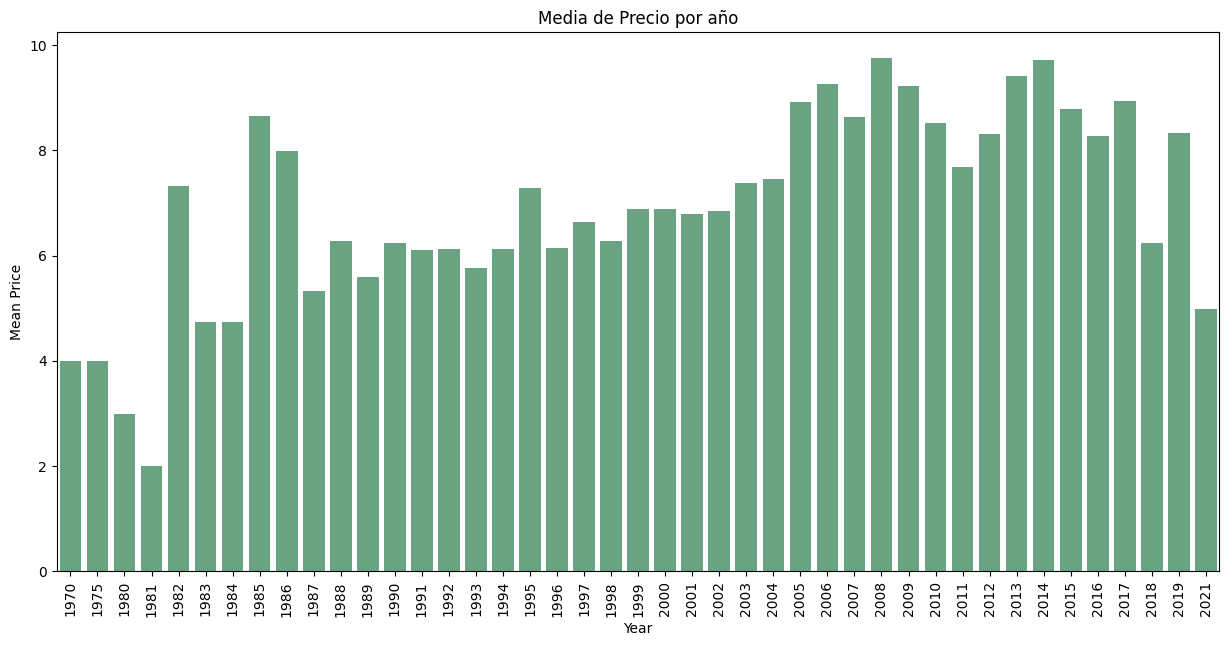

In [ ]:
# Visualizar la media de precio por año
mean_price_by_year = df.groupby('year')['price'].mean().reset_index()
fig, ax = plt.subplots(figsize=(15, 7))

sns.barplot(x='year', y='price', data=mean_price_by_year, color='#5fad80')
ax.set_title('Media de Precio por año')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Price')
ax.set_xticklabels(mean_price_by_year['year'], rotation=90)
plt.show()

## Visualización de Outliers

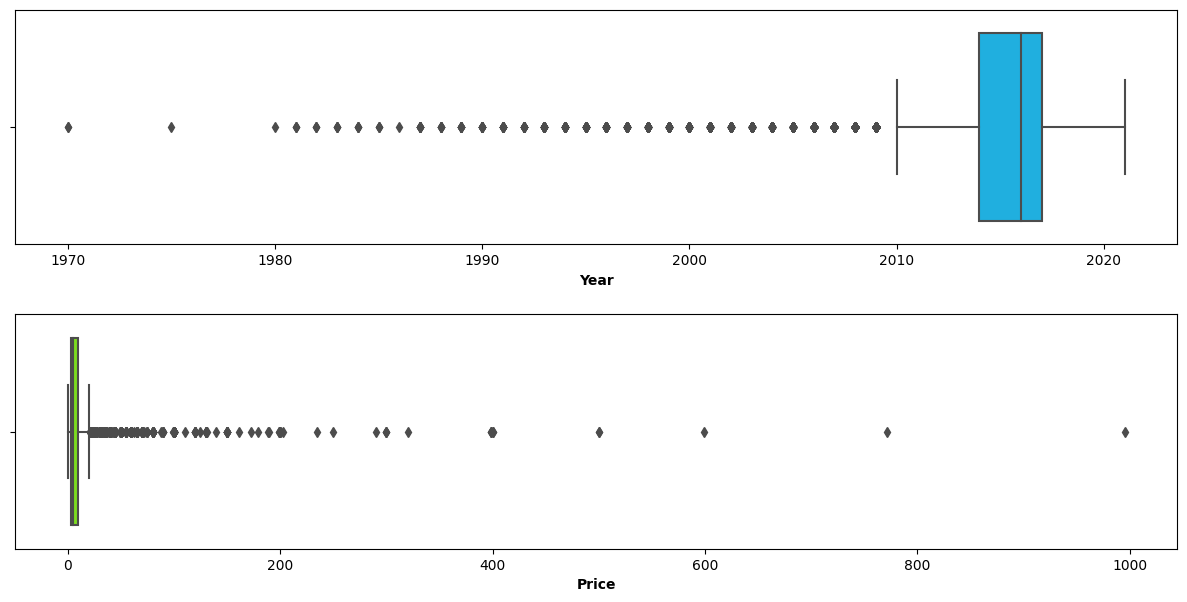

In [ ]:
# Visualizando la distribución de los precios y el año de lanzamiento de los juegos para detectar outliers
fig, ax = plt.subplots(2, 1, figsize=(15, 7))
plt.subplots_adjust(hspace=0.3)
colors = ['#00BFFF', '#7CFC00']

sns.boxplot(ax=ax[0], data=df, x='year', color=colors[0])
ax[0].set_xlabel('Year', fontweight='bold')
sns.boxplot(ax=ax[1], data=df, x='price', color=colors[1])
ax[1].set_xlabel('Price', fontweight='bold')
plt.show()

## Removiendo Outliers con IQR
■ Debido a la presencia de algunos Outliers en las columnas 'year' y 'price', se utiliza la técnica del Rango Intercuartil para la extracción de los mismos

In [ ]:
# Eliminando valores atípicos utilizando el Rango Intercuartil (IQR) para 'year' y 'price'
column_names = ['year', 'price']
for column_name in column_names:
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR)))]
    
df.head(4)

,price,early_access,year,month,Co-op,Downloadable Content,Full controller support,Multi-player,Partial Controller Support,Single-player,...,Action,Adventure,Casual,Free to Play,Indie,Massively Multiplayer,RPG,Simulation,Sports,Strategy
0,4.99,0,2018,1,0,0,0,0,0,1,...,1,0,1,0,1,0,0,1,0,1
1,0.00,0,2018,1,0,0,0,1,0,1,...,0,0,0,1,1,0,1,0,0,1
2,0.00,0,2017,7,0,0,0,1,0,1,...,0,0,1,1,1,0,0,1,1,0
3,0.99,0,2017,12,0,0,0,0,0,1,...,1,1,1,0,0,0,0,0,0,0


## Matriz de Correlación
Se crea un mapa de calor para visualizar la matriz de correlación del DataFrame, con el fin de identificar las relaciones entre las variables numéricas.

<Axes: >

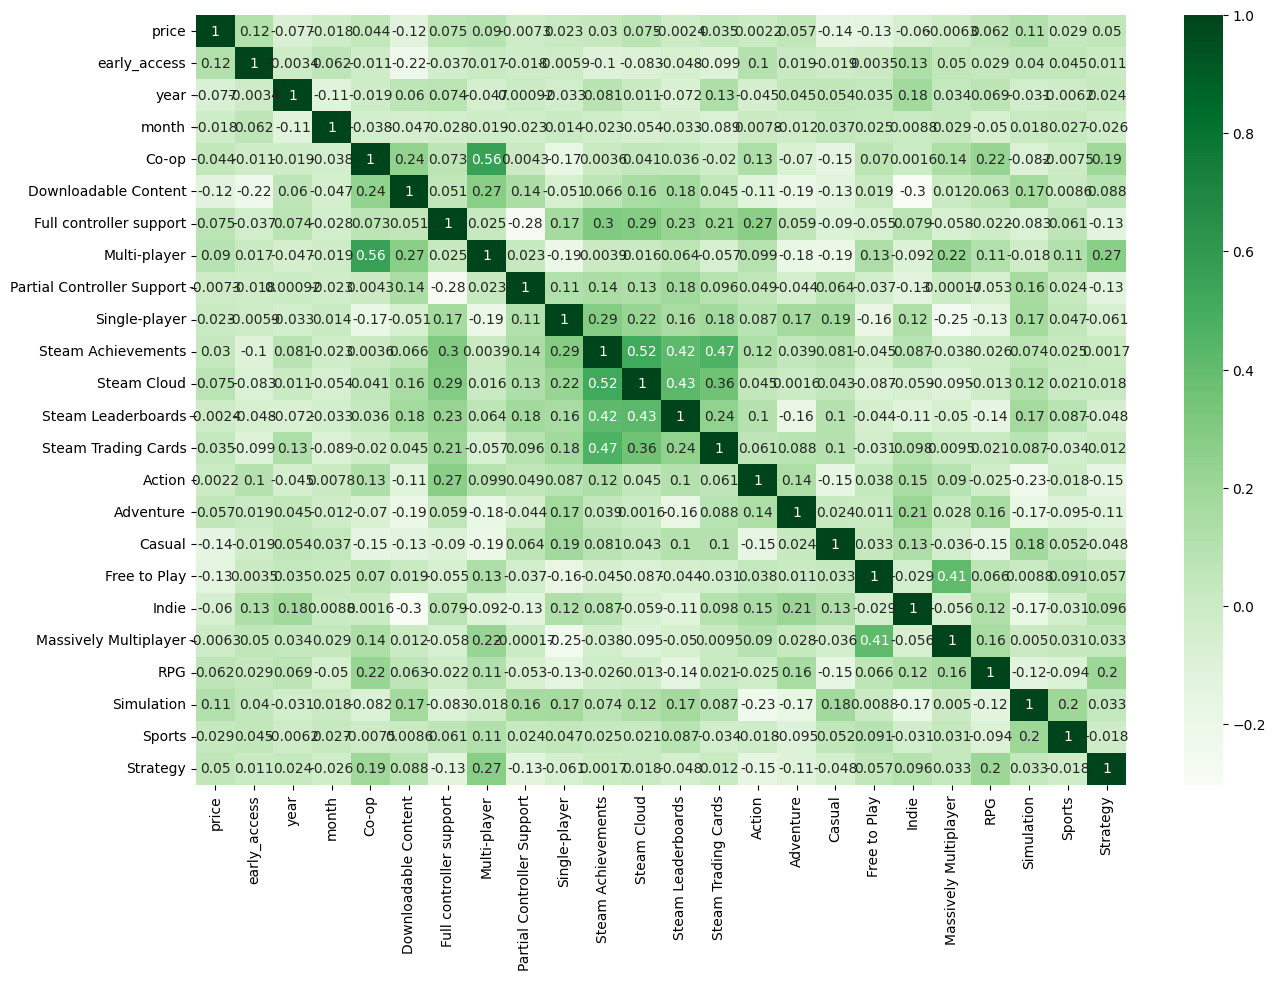

In [ ]:
# Mapa de calor para analizar la correlación entre las variables numéricas
plt.figure(figsize= (15, 10))
sns.heatmap(df.corr(), annot= True, cmap='Greens')

## Descripción estadística final del DataFrame

In [ ]:
df.dtypes

price                         float64
early_access                    Int64
year                            Int64
month                           Int64
Co-op                           int64
Downloadable Content            int64
Full controller support         int64
Multi-player                    int64
Partial Controller Support      int64
Single-player                   int64
Steam Achievements              int64
Steam Cloud                     int64
Steam Leaderboards              int64
Steam Trading Cards             int64
Action                          int64
Adventure                       int64
Casual                          int64
Free to Play                    int64
Indie                           int64
Massively Multiplayer           int64
RPG                             int64
Simulation                      int64
Sports                          int64
Strategy                        int64
dtype: object

In [ ]:
print(len(df))
print(df.isnull().sum())

28308
price                         0
early_access                  0
year                          0
month                         0
Co-op                         0
Downloadable Content          0
Full controller support       0
Multi-player                  0
Partial Controller Support    0
Single-player                 0
Steam Achievements            0
Steam Cloud                   0
Steam Leaderboards            0
Steam Trading Cards           0
Action                        0
Adventure                     0
Casual                        0
Free to Play                  0
Indie                         0
Massively Multiplayer         0
RPG                           0
Simulation                    0
Sports                        0
Strategy                      0
dtype: int64


In [ ]:
df.describe().head(3)

,price,early_access,year,month,Co-op,Downloadable Content,Full controller support,Multi-player,Partial Controller Support,Single-player,...,Action,Adventure,Casual,Free to Play,Indie,Massively Multiplayer,RPG,Simulation,Sports,Strategy
count,28308.000000,28308.0,28308.0,28308.0,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,...,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000
mean,6.366825,0.064328,2015.188039,7.245443,0.132860,0.414194,0.241027,0.242264,0.208775,0.868164,...,0.405680,0.308005,0.324361,0.071817,0.589551,0.034407,0.182563,0.238307,0.049880,0.232090
std,5.287115,0.245341,1.860904,3.355391,0.339429,0.492591,0.427714,0.428461,0.406440,0.338318,...,0.491032,0.461677,0.468144,0.258189,0.491924,0.182276,0.386315,0.426055,0.217701,0.422173


## Modelos de Machine Learning

■ Se lleva a cabo la implementación de diversos modelos de Machine Learning con el objetivo final de predecir el precio de los juegos y ver cual es el modelo más eficiente

■ Se utilizan 23 variables diferentes para realizar estas predicciones

■ Cada modelo se construye aplicando diversos parámetros y técnicas con el fin de mejorar la precisión y efectividad de las predicciones

■ Se prueban varios algoritmos, como 'Decision Tree Regression', 'Random Forest Regression', 'XGBoost Regression'

■ Se realizan ajustes en los hiperparámetros y se emplean técnicas de validación cruzada para evaluar el rendimiento de los modelos

## Set de Entrenamiento para el Modelo

In [ ]:
# División del conjunto de datos en características (X) y etiquetas (y)
X = df.drop(columns=['price'], axis= 1)
y = df['price']

# División del conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Decision Tree Regression

■ Se implementa el modelo de regresión de árbol de decisión para la predicción

■ Se emplea una búsqueda de hiperparámetros con validación cruzada para encontrar los mejores hiperparámetros para el modelo

In [ ]:
# Creando y entrenando el modelo de regresión de árbol de decisión
dtree = DecisionTreeRegressor()
param_grid = {
    'max_depth': [6, 7, 8, 9, 10,],
    'min_samples_split': [3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [3, 4, 6, 7, 8]
}

# Realizando una búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(dtree, param_grid, cv= 5)
grid_search.fit(X_train, y_train)

# Imprimiendo los mejores hiperparámetros encontrados por la búsqueda
print(grid_search.best_params_)

{'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 5}


Root Mean Squared Error: 4.46
R^2 Score: 0.3
       Precio Real  Precio Predicho  Diferencia
439           4.99         3.832620    1.157380
8758          0.99         3.458120   -2.468120
17746         5.99         4.918843    1.071157
15052         2.99         3.458120   -0.468120
12666         0.99         2.822027   -1.832027
29878         4.99         4.455690    0.534310
26290         1.99         4.424729   -2.434729
26903         4.99         4.424729    0.565271
21163        11.99         6.040847    5.949153
15770         9.99         9.075485    0.914515


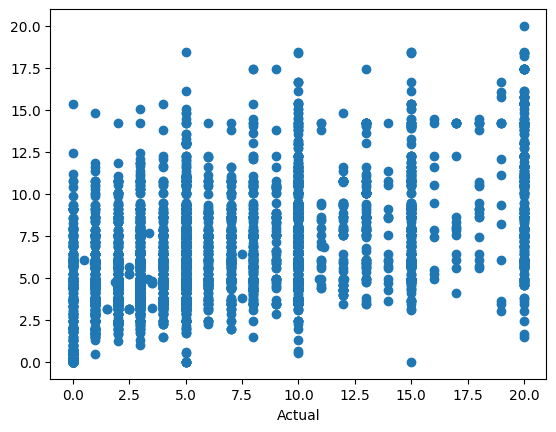

In [ ]:
# Creando y entrenando el modelo de regresión de árbol de decisión con los mejores hiperparámetros
dtree_best = DecisionTreeRegressor(random_state= 42, 
                                    max_depth= 9, 
                                    min_samples_leaf= 8, 
                                    min_samples_split= 7
)
dtree_best.fit(X_train, y_train)

# Realizando predicciones y evaluando el modelo
y_pred = dtree_best.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Imprimiendo métricas de rendimiento
print("Root Mean Squared Error:", round(rmse, 2))
print("R^2 Score:", round(r2, 2))

# Visualización de las predicciones frente a los valores reales
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')

# Creando un DataFrame con las diferencias entre los valores reales y las predicciones
diferencias_residuos = y_test - y_pred
resultados = pd.DataFrame({'Precio Real': y_test, 'Precio Predicho': y_pred, 'Diferencia': diferencias_residuos})
print(resultados.iloc[10:20])

## Random Forest Regression

■ Se utiliza el modelo de regresión de bosque aleatorio para la predicción

Root Mean Squared Error: 4.37
R^2 Score: 0.33
       Precio Real  Precio Predicho    Diferencia
439           4.99         4.990000 -6.217249e-15
8758          0.99         1.958607 -9.686071e-01
17746         5.99         3.740955  2.249045e+00
15052         2.99         2.840020  1.499800e-01
12666         0.99         4.081500 -3.091500e+00
29878         4.99         5.402505 -4.125046e-01
26290         1.99         4.272393 -2.282393e+00
26903         4.99         4.863600  1.264000e-01
21163        11.99         7.378667  4.611333e+00
15770         9.99        10.630400 -6.404000e-01


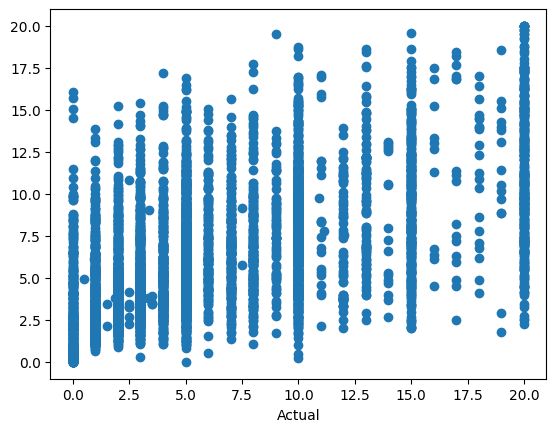

In [ ]:
# Creando y entrenando el modelo de regresión de bosque aleatorio
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Realizando predicciones y evaluando el modelo
y_pred = rf_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Imprimiendo métricas de rendimiento
print("Root Mean Squared Error:", round(rmse, 2))
print("R^2 Score:", round(r2, 2))

# Visualización de las predicciones frente a los valores reales
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')

# Creando un DataFrame con las diferencias entre los valores reales y las predicciones
diferencias_residuos = y_test - y_pred
resultados = pd.DataFrame({'Precio Real': y_test, 'Precio Predicho': y_pred, 'Diferencia': diferencias_residuos})
print(resultados.iloc[10:20])

## XGBoost Regression
■ Se implementa el modelo de regresión XGBoost para la predicción 

■ Se realiza una búsqueda aleatoria de hiperparámetros para encontrar los mejores valores para el modelo

In [ ]:
# Definiendo el rango de hiperparámetros para la búsqueda aleatoria
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [20, 50, 100],
    'learning_rate': [0.1, 0.2, 0.3],
}

# Creando y entrenando el modelo de regresión XGBoost con búsqueda aleatoria de hiperparámetros
xgb_model = xgb.XGBRegressor()
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=20, cv=5)
random_search.fit(X_train, y_train)

# Imprimiendo los mejores hiperparámetros encontrados por la búsqueda aleatoria
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}


Root Mean Squared Error: 4.23
R^2 Score: 0.37
       Precio Real  Precio Predicho  Diferencia
439           4.99         3.931379    1.058621
8758          0.99         2.984812   -1.994812
17746         5.99         4.253828    1.736172
15052         2.99         1.887102    1.102898
12666         0.99         2.542746   -1.552746
29878         4.99         5.728810   -0.738810
26290         1.99         3.530189   -1.540189
26903         4.99         4.334451    0.655549
21163        11.99         7.546808    4.443192
15770         9.99        10.099723   -0.109723


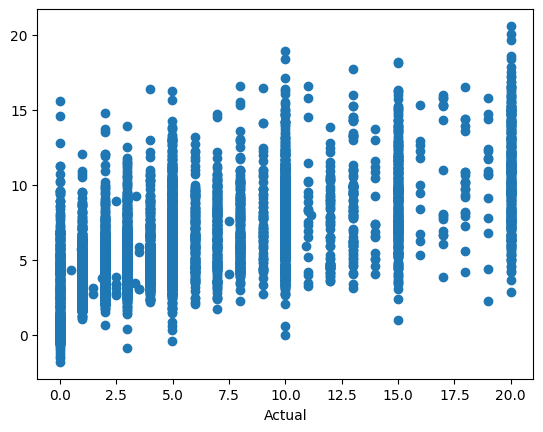

In [ ]:
# Creando y entrenando el modelo de regresión XGBoost con los mejores hiperparámetros
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Realizando las predicciones y evaluando el modelo
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Imprimiendo métricas de rendimiento
print("Root Mean Squared Error:", round(rmse, 2))
print("R^2 Score:", round(r2, 2))

# Visualización de las predicciones frente a los valores reales
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')

# Creando un DataFrame con las diferencias entre los valores reales y las predicciones
diferencias_residuos = y_test - y_pred
resultados = pd.DataFrame({'Precio Real': y_test, 'Precio Predicho': y_pred, 'Diferencia': diferencias_residuos})
print(resultados.iloc[10:20])

In [ ]:
# Guardar el modelo en un archivo utilizando pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

## Conclusion:
En este proyecto, hemos recorrido las tres etapas principales solicitadas: la Ingeniería de Datos, el Análisis Exploratorio y la Transformación de los Datos, y el modelado con técnicas de Machine Learning. Comenzamos tratando el Dataset, abordando sus falencias y preparándolo para su posterior análisis. A continuación, aplicamos tres modelos de Machine Learning diferentes, a saber, Decision Tree, Random Forest y XGBoost, para predecir el precio de los juegos en la plataforma Steam.

Durante la etapa de evaluación de los modelos, hemos utilizado métricas como el RMSE y el R^2 para medir su rendimiento y determinar cuál de ellos es más efectivo en la tarea de predicción de precios. Tras un exhaustivo análisis, concluimos que el modelo XGBoost ha demostrado ser el más preciso, con un RMSE de 4.23 puntos.

En este proyecto, hemos abordado desafíos reales de Machine Learning Operations y hemos aprendido a navegar a través del ciclo completo de un proyecto de este tipo, desde la preparación y exploración de los datos hasta la implementación de un modelo de predicción en una API accesible.